In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import sys
import glob
from os.path import join
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio 
import matplotlib.pyplot as plt
import rasterio.plot
import rasterio.mask
import json
import matplotlib.colors as mpc
import seaborn as sns
from matplotlib import ticker

from util.files import *
from util.const import *
from util.ddfs import *

In [3]:
# FIPS will be passed in as an argument, one day...
FIPS = '34007'
# STATE ABBR and NATION will be derived from FIPS, one day...
STATEABBR = 'NJ'
NATION = 'US'

SCENARIO = 'Mid'
DDF_TYPE = 'naccs'

# Load Data

In [4]:
# Load geospatial data
fz_geo = gpd.read_file(join(POL_DIR_I, FIPS, "fld_zones.gpkg"))
clip_geo = gpd.read_file(join(REF_DIR_I, FIPS, "clip.gpkg"))
tract_geo = gpd.read_file(join(REF_DIR_I, FIPS, "tract.gpkg"))
bg_geo = gpd.read_file(join(REF_DIR_I, FIPS, "bg.gpkg"))
nsi_geo = gpd.read_file(join(EXP_DIR_I, FIPS, "nsi_sf.gpkg"))

# including vulnerability data
lmi = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'lmi.gpkg'))
ovb = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'ovb.gpkg'))
cejst = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'cejst.gpkg'))
sovi = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'sovi.gpkg'))
# and the indicators dataframe to subset for maps
c_ind = pd.read_parquet(join(VULN_DIR_I, 'social', FIPS, 'c_indicators.pqt'))

In [5]:
# For the figures, we need the following data

# The objective evaluations for each policy
obj_filep = join(FO, 'pol_obj_vals.pqt')
objs = pd.read_parquet(obj_filep)

# The houses that are elevated for each policy
elev_ids_filep = join(FO, 'pol_elev_ids.json')
with open(elev_ids_filep, 'r') as fp:
    elev_ids = json.load(fp)

# The policies on the full pareto front
pareto_f_filep = join(FO, 'pareto_full.pqt')
# The pareto front for community based policies (may not need)
pareto_c_filep = join(FO, 'pareto_community.pqt')

pareto_f = pd.read_parquet(pareto_f_filep)
pareto_c = pd.read_parquet(pareto_c_filep)

# Metrics within each SOW
objs_sows_filep = join(FO, 'objs_sows.pqt')
objs_sows = pd.read_parquet(objs_sows_filep)

# The ensemble w/ opt heightenings & associated values
# We will do some plots based on the expected value of some
# metrics across SOWs
ens_filename = 'ensemble_' + SCENARIO + '.pqt'
ens_df = pd.read_parquet(join(FO, ens_filename))

opt_elev_filename = 'ens_opt_elev_' + DDF_TYPE + '_' + SCENARIO + '.pqt'
opt_elev_df = pd.read_parquet(join(EXP_DIR_I, FIPS, opt_elev_filename))
ens_df = ens_df.merge(opt_elev_df,
                      on=['fd_id', 'sow_ind'],
                      suffixes=['','_opt'])

In [6]:
# Get ens_agg for rel_eal, resid_rel_eal, & val_s metrics
ens_df['rel_eal'] = ens_df[DDF_TYPE + '_eal']/ens_df['val_s']
ens_agg = ens_df.groupby('fd_id')[['rel_eal', 
                                   'resid_rel_eal',
                                   'val_s']].mean().reset_index()

# We need to merge ens_agg with nsi_geo 
ens_agg_plot = nsi_geo.merge(ens_agg,
                             how='inner',
                             on='fd_id')

In [7]:
# Subset sovi and lmi based on their threshholds
sovi = sovi[sovi['SOVI0610' + STATEABBR] > .75]
lmi = lmi[lmi['Lowmod_pct'] > .5]

# Main Figures

## Figure 1

In [148]:
# # Figure 1
# # Each row will correspond to a different 
# # community prioritization definition
# # First col will be the maps with the boundaries highlighted, 
# # and all the structures plotted with eal. 
# # Second col will be the same but for rel_eal. 
# # This figure  sets the stage for issues 
# # with using these boundaries and the sharp discontinuities 
# # they create over space. It also raises the point of spatial 
# # resolution (SOVI is tracts, not block group. So, while you 
# # think you’re doing better because you are getting finer 
# # resolution community characteristics, you actually can leave 
# # out more homes with higher risk - even after taking out 
# # the influence of structure value). 
# # Need color legends at bottom, different sequential colormaps
# # for eal vs rel_eal, be consistent throughout the paper

# # We need the vulnerability geodata
# # We need the ens_agg dataframe

# # Loop through each of the vulnerability layers
# # Plot them on the clip_geo file using 
# # different colors for their boundaries
# # and an subplot title in the same color
# # Plot ens_agg points in eal and rel_eal in
# # different columns

# comm_list = [sovi, cejst, ovb, lmi]

# # Colormaps for each of eal_base and rel_eal
# # from colorbrewer multihue
# # https://colorbrewer2.org/#type=sequential&scheme=RdPu&n=5
# cmap_eal_l = ['#feebe2', '#fbb4b9', '#f768a1', '#c51b8a', '#7a0177']
# cmap_eal = mpc.LinearSegmentedColormap.from_list("", cmap_eal_l)

# cmap_eal_r_l = ['#fef0d9', '#fdcc8a', '#fc8d59', '#e34a33', '#b30000']
# cmap_eal_r = mpc.LinearSegmentedColormap.from_list("", cmap_eal_r_l)


# title_dict = {
#     'lmi': 'FHA Low-Mod Income',
#     'sovi': 'NOAA Socially Vuln.' ,
#     'cejst': 'Justice40 Comm.',
#     'ovb': 'NJ Overburdened'
# }

# comm_names = ['sovi', 'cejst', 'ovb', 'lmi']

# fig, ax = plt.subplots(figsize=(10, 5),
#                        nrows=2,
#                        ncols=4,
#                        dpi=600,
#                        gridspec_kw = {'wspace':.01,'hspace': 0.01})

# # Helps to zoom in on places where at-risk homes are
# total_bounds = ens_agg_plot.geometry.total_bounds
# buffer = .001
# minx = total_bounds[0] - buffer
# maxx = total_bounds[2] + buffer
# miny = total_bounds[1] - buffer
# maxy = total_bounds[3] + buffer

# # Loop through each layer
# for i, comm_geo in enumerate(comm_list):
#     # Reproject layer to tract crs
#     comm_plot = comm_geo.to_crs(tract_geo.crs)
    
#     # Layer name
#     name_l = comm_names[i]

#     # Plot the layer boundary in each column
#     comm_plot.plot(ax=ax[0, i],
#                   color='lightgray',
#                    edgecolor='none')

#     comm_plot.plot(ax=ax[1, i],
#                   color='lightgray',
#                    edgecolor='lightgray')

#     # Plot census tract boundaries in each column
#     tract_geo.plot(ax=ax[0, i],
#                    edgecolor='black',
#                    color='none',
#                    lw=.5)
#     tract_geo.plot(ax=ax[1, i],
#                    edgecolor='black',
#                    color='none',
#                    lw=.5)

#     # Caption the subplot title
#     ax[0, i].set_title(title_dict[name_l],
#                         size=12)
    
#     # Plot the eal
#     vmin_eal = 0
#     # Use 98th percentile because the distribution is long tailed
#     vmax_eal = ens_agg_plot['base_eal'].quantile(.98)
#     # Sort before plotting
#     ens_agg_plot = ens_agg_plot.sort_values('base_eal', ascending=True)
#     ens_agg_plot.plot(ax=ax[0, i],
#                       column='base_eal',
#                       cmap=cmap_eal,
#                       s=1,
#                       vmin=vmin_eal,
#                       vmax=vmax_eal)
    
    
#     # Plot the rel_eal
#     vmin_rel_eal = 0
#     vmax_rel_eal = ens_agg_plot['rel_eal'].max()
#     ens_agg_plot = ens_agg_plot.sort_values('rel_eal', ascending=True)
#     ens_agg_plot.plot(ax=ax[1, i],
#                       column='rel_eal',
#                       cmap=cmap_eal_r,
#                       s=1,
#                       vmin=vmin_rel_eal,
#                       vmax=vmax_rel_eal)

#     # Set axis off but keep outline
#     ax[0, i].tick_params(axis='both',
#                          which='both',
#                          bottom=False,
#                          left=False,
#                          labelbottom=False,
#                          labelleft=False)

#     ax[1, i].tick_params(axis='both',
#                          which='both',
#                          bottom=False,
#                          left=False,
#                          labelbottom=False,
#                          labelleft=False)

#     # Zoom in on points
#     ax[0, i].set_xlim([minx, maxx])
#     ax[1, i].set_xlim([minx, maxx])
#     ax[0, i].set_ylim([miny, maxy])
#     ax[1, i].set_ylim([miny, maxy])


# # Add continuous legends
# cax = fig.add_axes([.95, 0.54, .01, 0.3])
# sm = plt.cm.ScalarMappable(cmap=cmap_eal,
#                            norm=plt.Normalize(vmin=vmin_eal,
#                                               vmax=vmax_eal))
# sm._A = []
# cbr = fig.colorbar(sm, cax=cax, orientation='vertical', extend='max')
# cbr.ax.tick_params(labelsize=8) 
# cbr.ax.yaxis.set_ticks_position('left')
# cbr.set_label("$ Expected Annual Loss\n(Ensemble Mean)", size=8,
#               rotation=270,
#               labelpad=20)

# cax = fig.add_axes([.95, .16, 0.01, 0.3])
# sm = plt.cm.ScalarMappable(cmap=cmap_eal_r,
#                            norm=plt.Normalize(vmin=vmin_rel_eal,
#                                               vmax=vmax_rel_eal))
# sm._A = []
# cbr = fig.colorbar(sm, cax=cax, orientation='vertical')
# cbr.ax.tick_params(labelsize=8) 
# cbr.ax.yaxis.set_ticks_position('left')
# cbr.set_label("Relative Expected Annual Loss\n(Ensemble Mean)", size=8,
#               rotation=270,
#               labelpad=20)

# fig.savefig(join(FIG_DIR, 'Figure1.png'),
#             dpi=600,
#             bbox_inches='tight')

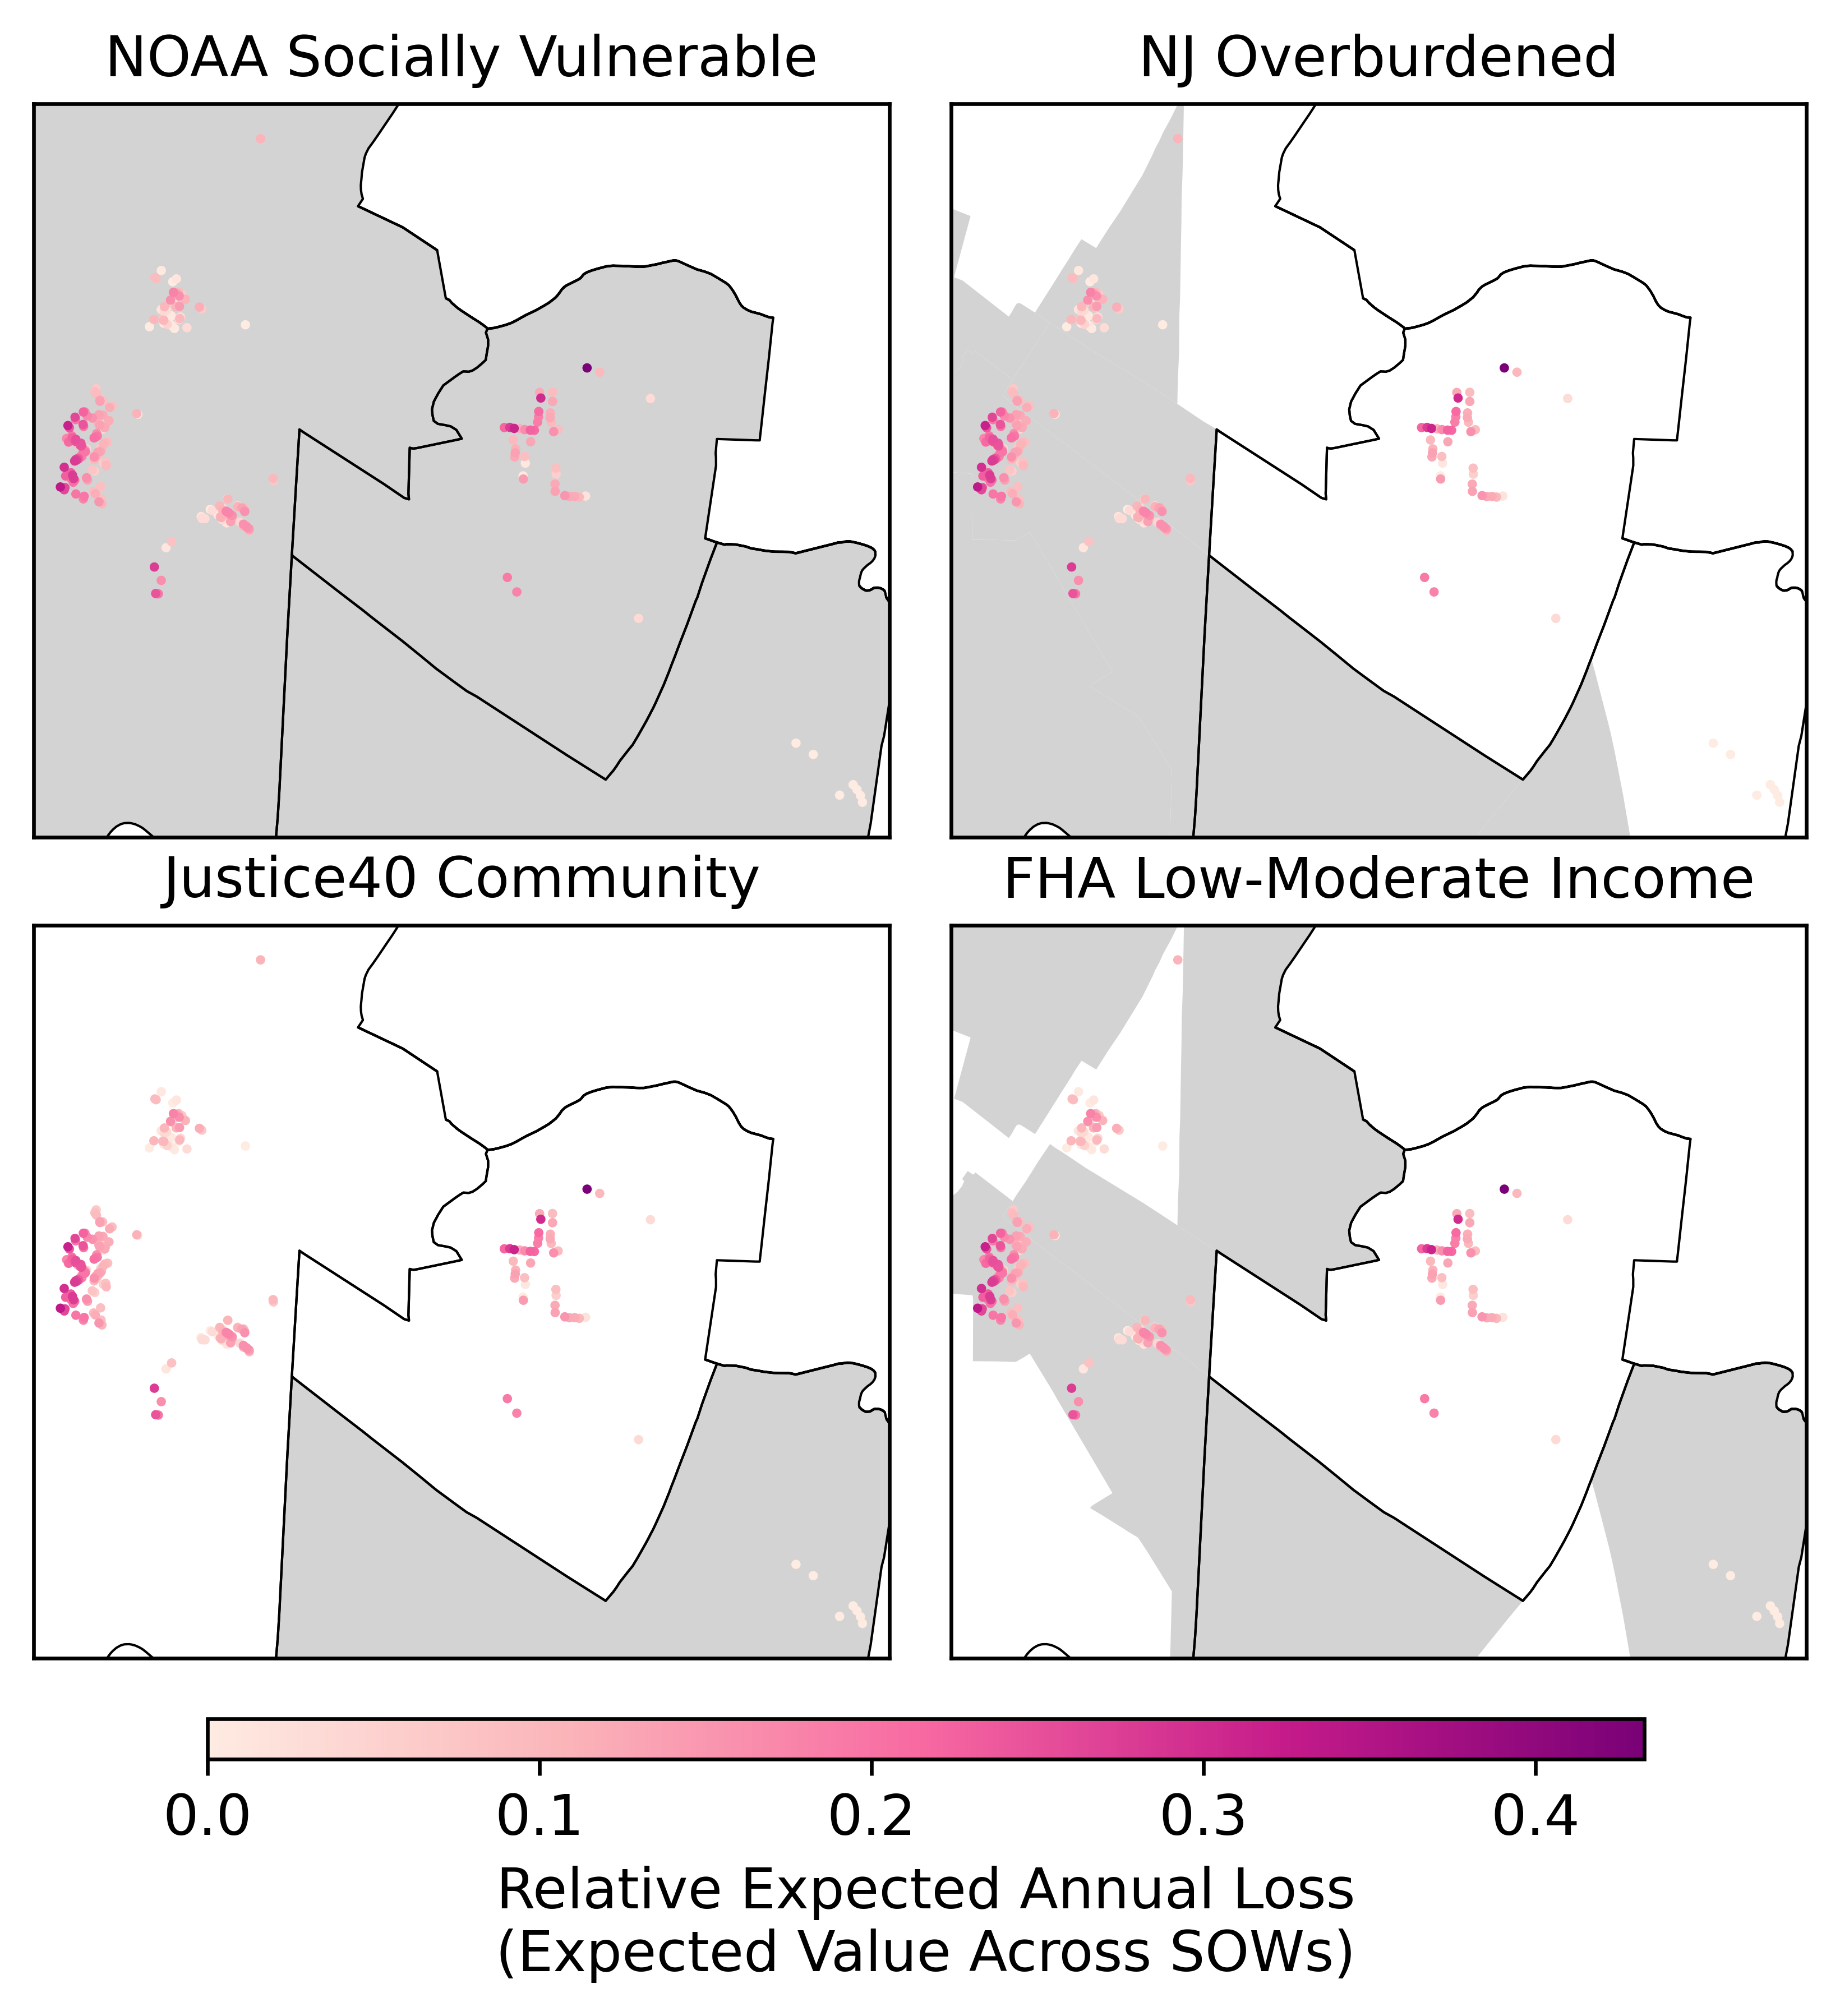

In [149]:
# Figure 1
# Let's just focus on the community boundaries & eal

comm_list = [sovi, cejst, ovb, lmi]

# Colormaps for eal_base 
# from colorbrewer multihue
# https://colorbrewer2.org/#type=sequential&scheme=RdPu&n=5
cmap_eal_l = ['#feebe2', '#fbb4b9', '#f768a1', '#c51b8a', '#7a0177']
cmap_eal = mpc.LinearSegmentedColormap.from_list("", cmap_eal_l)


title_dict = {
    'lmi': 'FHA Low-Moderate Income',
    'sovi': 'NOAA Socially Vulnerable' ,
    'cejst': 'Justice40 Community',
    'ovb': 'NJ Overburdened'
}

comm_names = ['sovi', 'cejst', 'ovb', 'lmi']

fig, ax = plt.subplots(figsize=(7, 6),
                       nrows=2,
                       ncols=2,
                       dpi=600,
                       gridspec_kw = {'wspace':.01,'hspace': .12})

# Helps to zoom in on places where at-risk homes are
total_bounds = ens_agg_plot.geometry.total_bounds
buffer = .001
minx = total_bounds[0] - buffer
maxx = total_bounds[2] + buffer
miny = total_bounds[1] - buffer
maxy = total_bounds[3] + buffer

# Loop through each layer
for i, comm_geo in enumerate(comm_list):
    row = i%2
    col = i//2
    
    # Reproject layer to tract crs
    comm_plot = comm_geo.to_crs(tract_geo.crs)
    
    # Layer name
    name_l = comm_names[i]

    # Plot the layer boundary in each column
    comm_plot.plot(ax=ax[row, col],
                   color='lightgray',
                   edgecolor='none')

    # Plot census tract boundaries in each column
    tract_geo.plot(ax=ax[row, col],
                   edgecolor='black',
                   color='none',
                   lw=.5)

    # Caption the subplot title
    ax[row, col].set_title(title_dict[name_l],
                           size=12)
    
    # Plot the eal
    vmin_eal = 0
    vmax_eal = ens_agg_plot['rel_eal'].max()
    # Sort before plotting
    ens_agg_plot = ens_agg_plot.sort_values('rel_eal', ascending=True)
    ens_agg_plot.plot(ax=ax[row, col],
                      column='rel_eal',
                      cmap=cmap_eal,
                      s=1,
                      vmin=vmin_eal,
                      vmax=vmax_eal)

    # Set axis off but keep outline
    ax[row, col].tick_params(axis='both',
                             which='both',
                             bottom=False,
                             left=False,
                             labelbottom=False,
                             labelleft=False)

    # Zoom in on points
    ax[row, col].set_xlim([minx, maxx])
    ax[row, col].set_ylim([miny, maxy])


# Add continuous legends
cax = fig.add_axes([.21, 0.06, .61, 0.02])
sm = plt.cm.ScalarMappable(cmap=cmap_eal,
                           norm=plt.Normalize(vmin=vmin_eal,
                                              vmax=vmax_eal))
sm._A = []
cbr = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbr.ax.tick_params(labelsize=12) 
cbr.set_label("Relative Expected Annual Loss\n(Expected Value Across SOWs)", size=12)

fig.savefig(join(FIG_DIR, 'Figure1.png'),
            dpi=600,
            bbox_inches='tight')

## Figure 2

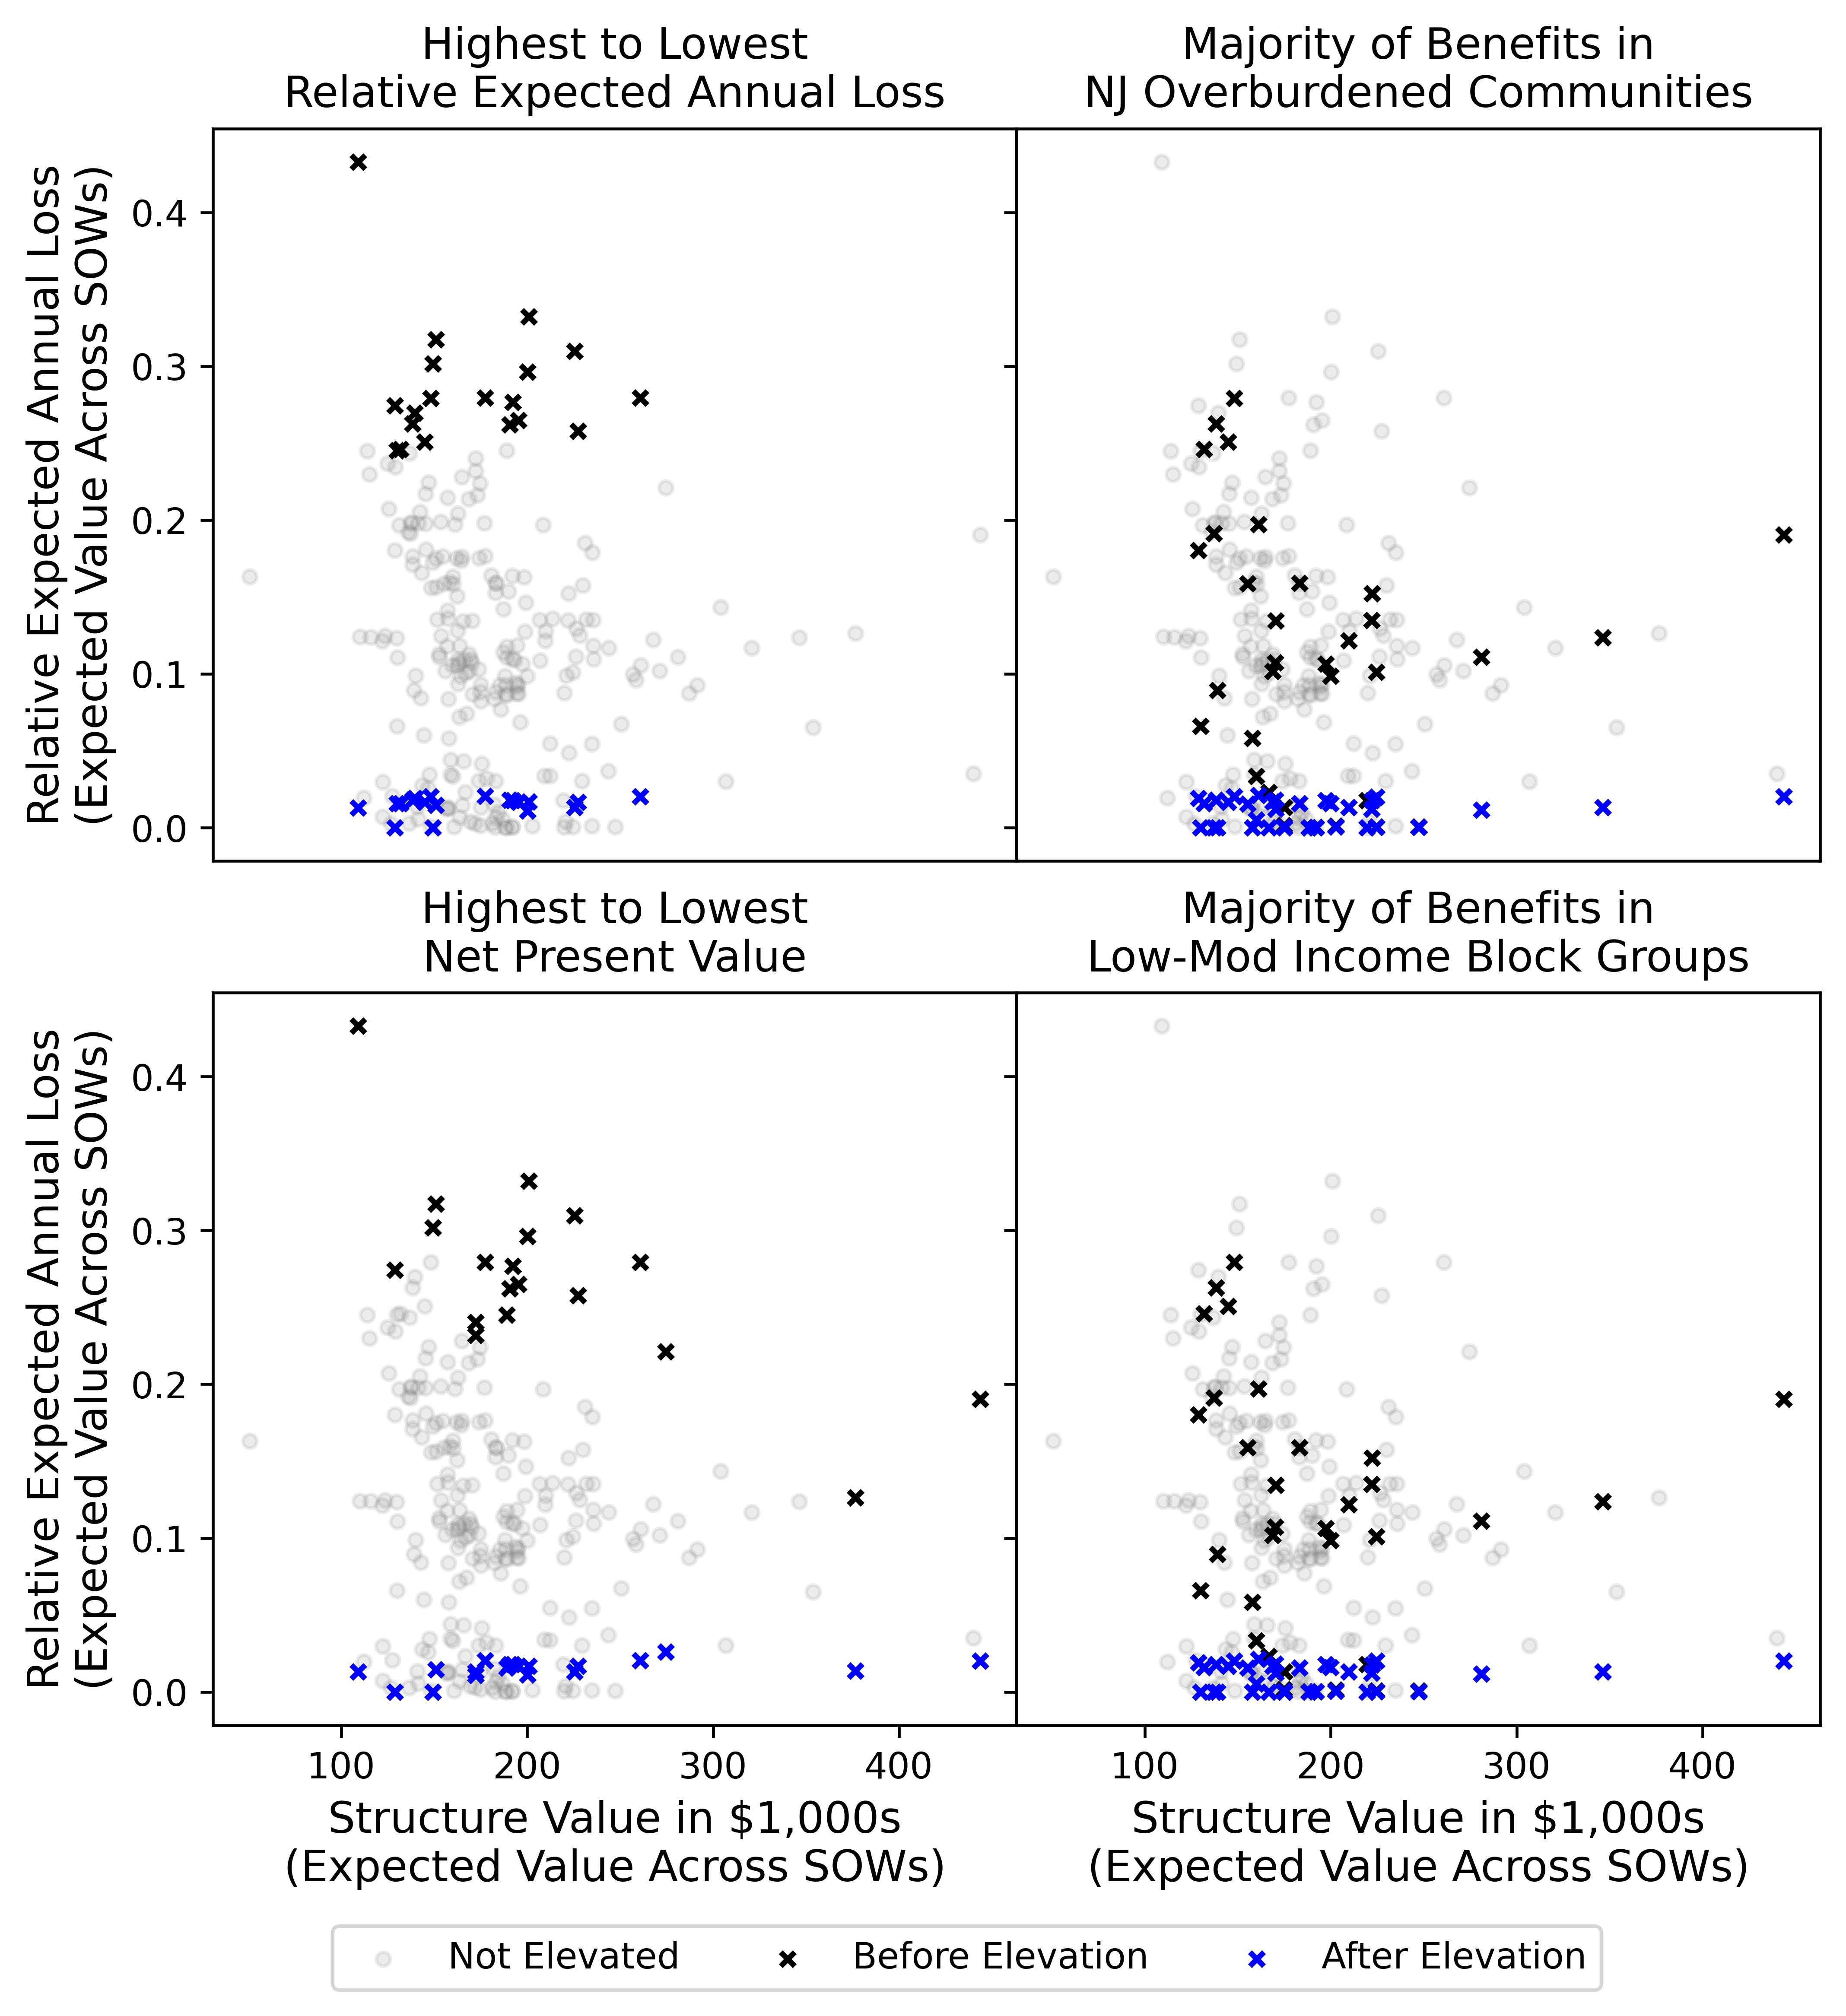

In [150]:
# Figure 2
# rel_eal (y) & val_s (x) plots for each community definition
# For a $1M budget, what homes get elevated according to
# sorting by rel_eal vs. community sorting rules?
# We'll look at NJ ovb & LMI since SOVI is same
# as sorting by eal, since each home is in a NOAA SOVI tract
# We won't look at Justice40 because a project that makes sure
# we get the majority of benefits in that community will do
# poorly on other objectives (we formally show this later)
# Gray out the points that are not elevated by a sorting rule
# Show for the 4 sorting rules what you get, then for
# other columns do $3M budget and $6M budget
# In the text, point out that these roughly correspond to the
# 25th, 50th and 75th percentile awarded project amounts
# that met our filtering criteria. 

# I think this is good motivation for wanting to 
# measure on the intensive & extensive margin to get at equity. 

# We need the ens_agg dataframe
# We also need to extract the requisite policies from
# elev_ids

# The below just serves as a template
# Need to structure it into a 2x2 plot
# Just use the 3M budget since it's the median budget
# from our filter (we show for all budgets later, but
# more formally in terms of objectives) 
# We are looking at 1 household equity sorting rule
# 1 household efficiency sorting rule
# 2 community rules
# Put the line on the residual risk
# to show how it changes in terms of equality
# and the new average residual risk (horizontal line)
# Explain how these are useful equity metrics in tandem

# Some preprocessing to help the plotting look nicer
# get structural value in thousands
ens_agg_plot['val_s_thou'] = ens_agg_plot['val_s']/1e3

fig, ax = plt.subplots(figsize=(8, 8),
                       nrows=2,
                       ncols=2,
                       dpi=600,
                       sharey=True,
                       sharex=True,
                       gridspec_kw = {'wspace':0,'hspace': .18})

size = 15
alpha=.5

budget = 3e6

sort_cols = ['rel_eal', 'sovi',
             'ovb', 'lmi']

title_dict = {
    'lmi': 'Majority of Benefits in\nLow-Mod Income Block Groups',
    'sovi': 'Highest to Lowest\nNet Present Value' ,
    'ovb': 'Majority of Benefits in\nNJ Overburdened Communities',
    'rel_eal': 'Highest to Lowest\nRelative Expected Annual Loss'
}

for i, sort in enumerate(sort_cols):
    row = i % 2
    col = i // 2

    # Find the policy
    policy = sort + '_' + str(budget)
    fd_ids = elev_ids[policy]

    # Subset into homes that are elevated for this policy
    elevated = ens_agg_plot.loc[ens_agg_plot['fd_id'].isin(fd_ids)]
    not_elev = ens_agg_plot.loc[~ens_agg_plot['fd_id'].isin(fd_ids)]

    # Plot the points
    not_elev.plot(x='val_s_thou',
                  y='rel_eal',
                  kind='scatter',
                  color='gray',
                  label='Not Elevated',
                  s=size,
                  alpha=alpha-.35,
                  ax=ax[row, col])

    # Also plot the old elevated points
    elevated.plot(x='val_s_thou',
                  y='rel_eal',
                  kind='scatter',
                  color='black',
                  label='Before Elevation',
                  marker='x',
                  s=size,
                  ax=ax[row, col])
    
    elevated.plot(x='val_s_thou',
                  y='resid_rel_eal',
                  kind='scatter',
                  color='blue',
                  label='After Elevation',
                  marker='x',
                  s=size,
                  ax=ax[row, col])
    
    # Add title
    ax[row, col].set_title(title_dict[sort],
                           size=12)
    
    # Clean up the plot
    # Remove left ticks from each axis in column 1
    # ax[row, 1].tick_params(axis='both',
    #                        which='both',
    #                        left=False)
    # Remove bottom ticks from each axis in row 1
    ax[0, col].tick_params(axis='both',
                           which='both',
                           bottom=False)

    # Update labels
    ax[row, 0].set_ylabel('Relative Expected Annual Loss\n(Expected Value Across SOWs)',
                          size=12)
    ax[1, col].set_xlabel('Structure Value in $1,000s\n(Expected Value Across SOWs)',
                          size=12)

ax[0, 1].get_legend().remove()
ax[1, 1].get_legend().remove()
ax[0, 0].get_legend().remove()

ax[1, 0].legend(bbox_to_anchor=(1.75, -.25),
                ncols=3)

fig.savefig(join(FIG_DIR, 'Figure2.png'),
            dpi=600,
            bbox_inches='tight')

## Figure 3

In [326]:
# # Figure 3
# # Want to show marginal distributions for the 2 equity metrics
# # and the npv for the different sorting rules. We will do
# # community and household rules on different rows. We will
# # do the different metrics as different columns
# # So this is a grid axis
# # Do histograms (budgets are changing)
# # Says nothing direclty about the pareto front, but hints at what
# # policies dominate on different dimensions
# # And this is especially important for the story of our paper
# # comparing community prioritization criteria to 
# # household equity indicators
# # Gives us the visual cues to talk about sovi dominating cejst
# # even though FEMA just changed from sovi to cejst
# # Allows us to explain that new FEMA critical disaster 
# # resilience zones are not even in our community
# # Allows us to show that the rel_eal based sorting (household
# # equity indicators) dominates efficiency based sorting (i.e. npv)
# # Need to make it so that all axes share the same direction
# # of prference. I think that is visually nicer
# # Community rules are different colors & dotted
# # Household "" & solid (different colors than above)
# # No fill on the histograms
# # Share x axis no columns & y axis all

# # Using the "light" scheme
# # https://cran.r-project.org/web/packages/khroma/vignettes/tol.html

# # Community colors
# comm_cols = ["#77AADD",
#              "#EE8866",
#              "#EEDD88",
#              "#FFAABB"]

# # Household colors
# house_cols = ["#99DDFF",
#               "#44BB99",
#               "#BBCC33"]

# # We need the objs_sows dataframe

# fig, ax = plt.subplots(figsize=(8, 6),
#                        nrows=3,
#                        ncols=2,
#                        sharey='row',
#                        dpi=600)

# # We are looping through avoid_eq, resid_eq, and npv
# plot_cols = ['avoid_eq', 'resid_eq', 'npv_plot']
# # NPV in millions plots better
# objs_sows['npv_plot'] = objs_sows['npv']/1e6

# # We are plotting community sorting rules on the top row
# # and the household sorting rules on the bottom 
# c_sort_cols =  ['cejst', 'lmi', 'ovb', 'sovi']
# h_sort_cols = ['rel_eal', 'avoid_rel_eal',
#                'pv_resid']

# # We can get subsets based on these policies to help with plotting
# c_marg = objs_sows[objs_sows['sort'].isin(c_sort_cols)].reset_index(drop=True)
# h_marg = objs_sows[objs_sows['sort'].isin(h_sort_cols)].reset_index(drop=True)

# # We loop through the plot cols
# # For each one, we want to pivot c_marg and h_marg on budget index
# # with the sort columns as columns and the plot_col as the value
# for i, pc in enumerate(plot_cols):
#     hist_c = c_marg.pivot(index=['sow_ind', 'budget'],
#                           columns='sort',
#                           values=pc).reset_index()[c_sort_cols]
#     hist_h = h_marg.pivot(index=['sow_ind', 'budget'],
#                           columns='sort',
#                           values=pc).reset_index()[h_sort_cols]

#     # Community on top, household on bottom
#     # Want total height to equal 1
#     weights_c = np.ones_like(hist_c)/float(len(hist_c))
#     weights_h = np.ones_like(hist_h)/float(len(hist_h))
#     ax[i, 0].hist(hist_c,
#                   bins=10,
#                   histtype='bar',
#                   weights=weights_c,
#                   color=comm_cols,
#                   stacked=False)
#     ax[i, 1].hist(hist_h,
#                   bins=10,
#                   histtype='bar',
#                   weights=weights_h,
#                   color=house_cols,
#                   stacked=False)

#     # We want to invert the x axis for the first two rows
#     # but we also want to align each row on the same
#     # y limits. You can't do both when you set
#     # sharex='col' (at least when I tried), so we can manually align
#     # and then reverse. 
#     # First, aligning. 
#     minx = np.min([ax[i, 0].get_xlim()[0], ax[i, 0].get_xlim()[0]])
#     maxx = np.max([ax[i, 1].get_xlim()[1], ax[i, 1].get_xlim()[1]])
#     for j in [0, 1]:
#         ax[i, j].set_xlim(minx, maxx)
#         # While we're at it... reformat y labels for each plot
#         reformat = "{x: .0%}"
#         ax[i, j].yaxis.set_major_formatter(ticker.StrMethodFormatter(reformat))
    
#     # For i < 2, invert x-axis (want all same direction)
#     if i < 2:
#         ax[i, 0].set_xlim(ax[i, 0].get_xlim()[::-1])
#         ax[i, 1].set_xlim(ax[i, 1].get_xlim()[::-1])

# # Label each column
# ax[0, 0].set_title('Community Prioritization\nRules Produce', size=12)
# ax[0, 1].set_title('Household Prioritization\nRules Produce', size=12)

# # Label the y axes
# ax[0, 0].set_ylabel('In Y % of SOWs', size=12)
# ax[1, 0].set_ylabel('In Y % of SOWs', size=12)
# ax[2, 0].set_ylabel('In Y % of SOWs', size=12)
# # Label x axis
# ax[0, 0].set_xlabel('This Level of Average Residual Relative Risk', size=12)
# ax[1, 0].set_xlabel('This Level of Inequality in Residual Relative Risk', size=12)
# ax[2, 0].set_xlabel('This Level of Net Present Value ($ Millions)', size=12)
# # And move it over...
# ax[0, 0].xaxis.set_label_coords(1.01, -.22)
# ax[1, 0].xaxis.set_label_coords(1.05, -.22)
# ax[2, 0].xaxis.set_label_coords(1.03, -.22)

# # Annotate direction of improvement
# ax[0, 0].annotate('Direction of\nImprovement',
#                   xy=(.95, .85), xycoords='axes fraction',
#                   xytext=(0.7, 0.85), textcoords='axes fraction',
#                   arrowprops=dict(facecolor='black',
#                                   width=.01,
#                                   headlength=5,
#                                   headwidth=5),
#                   fontsize=8,
#                   horizontalalignment='center',
#                   verticalalignment='center')

# ax[1, 0].annotate('Direction of\nImprovement',
#                   xy=(.95, .85), xycoords='axes fraction',
#                   xytext=(0.7, 0.85), textcoords='axes fraction',
#                   arrowprops=dict(facecolor='black',
#                                   width=.01,
#                                   headlength=5,
#                                   headwidth=5),
#                   fontsize=8,
#                   horizontalalignment='center',
#                   verticalalignment='center')

# ax[2, 0].annotate('Direction of\nImprovement',
#                   xy=(.95, .85), xycoords='axes fraction',
#                   xytext=(0.7, 0.85), textcoords='axes fraction',
#                   arrowprops=dict(facecolor='black',
#                                   width=.01,
#                                   headlength=5,
#                                   headwidth=5),
#                   fontsize=8,
#                   horizontalalignment='center',
#                   verticalalignment='center')
# fig.align_ylabels(ax[:, 0])
# fig.tight_layout()

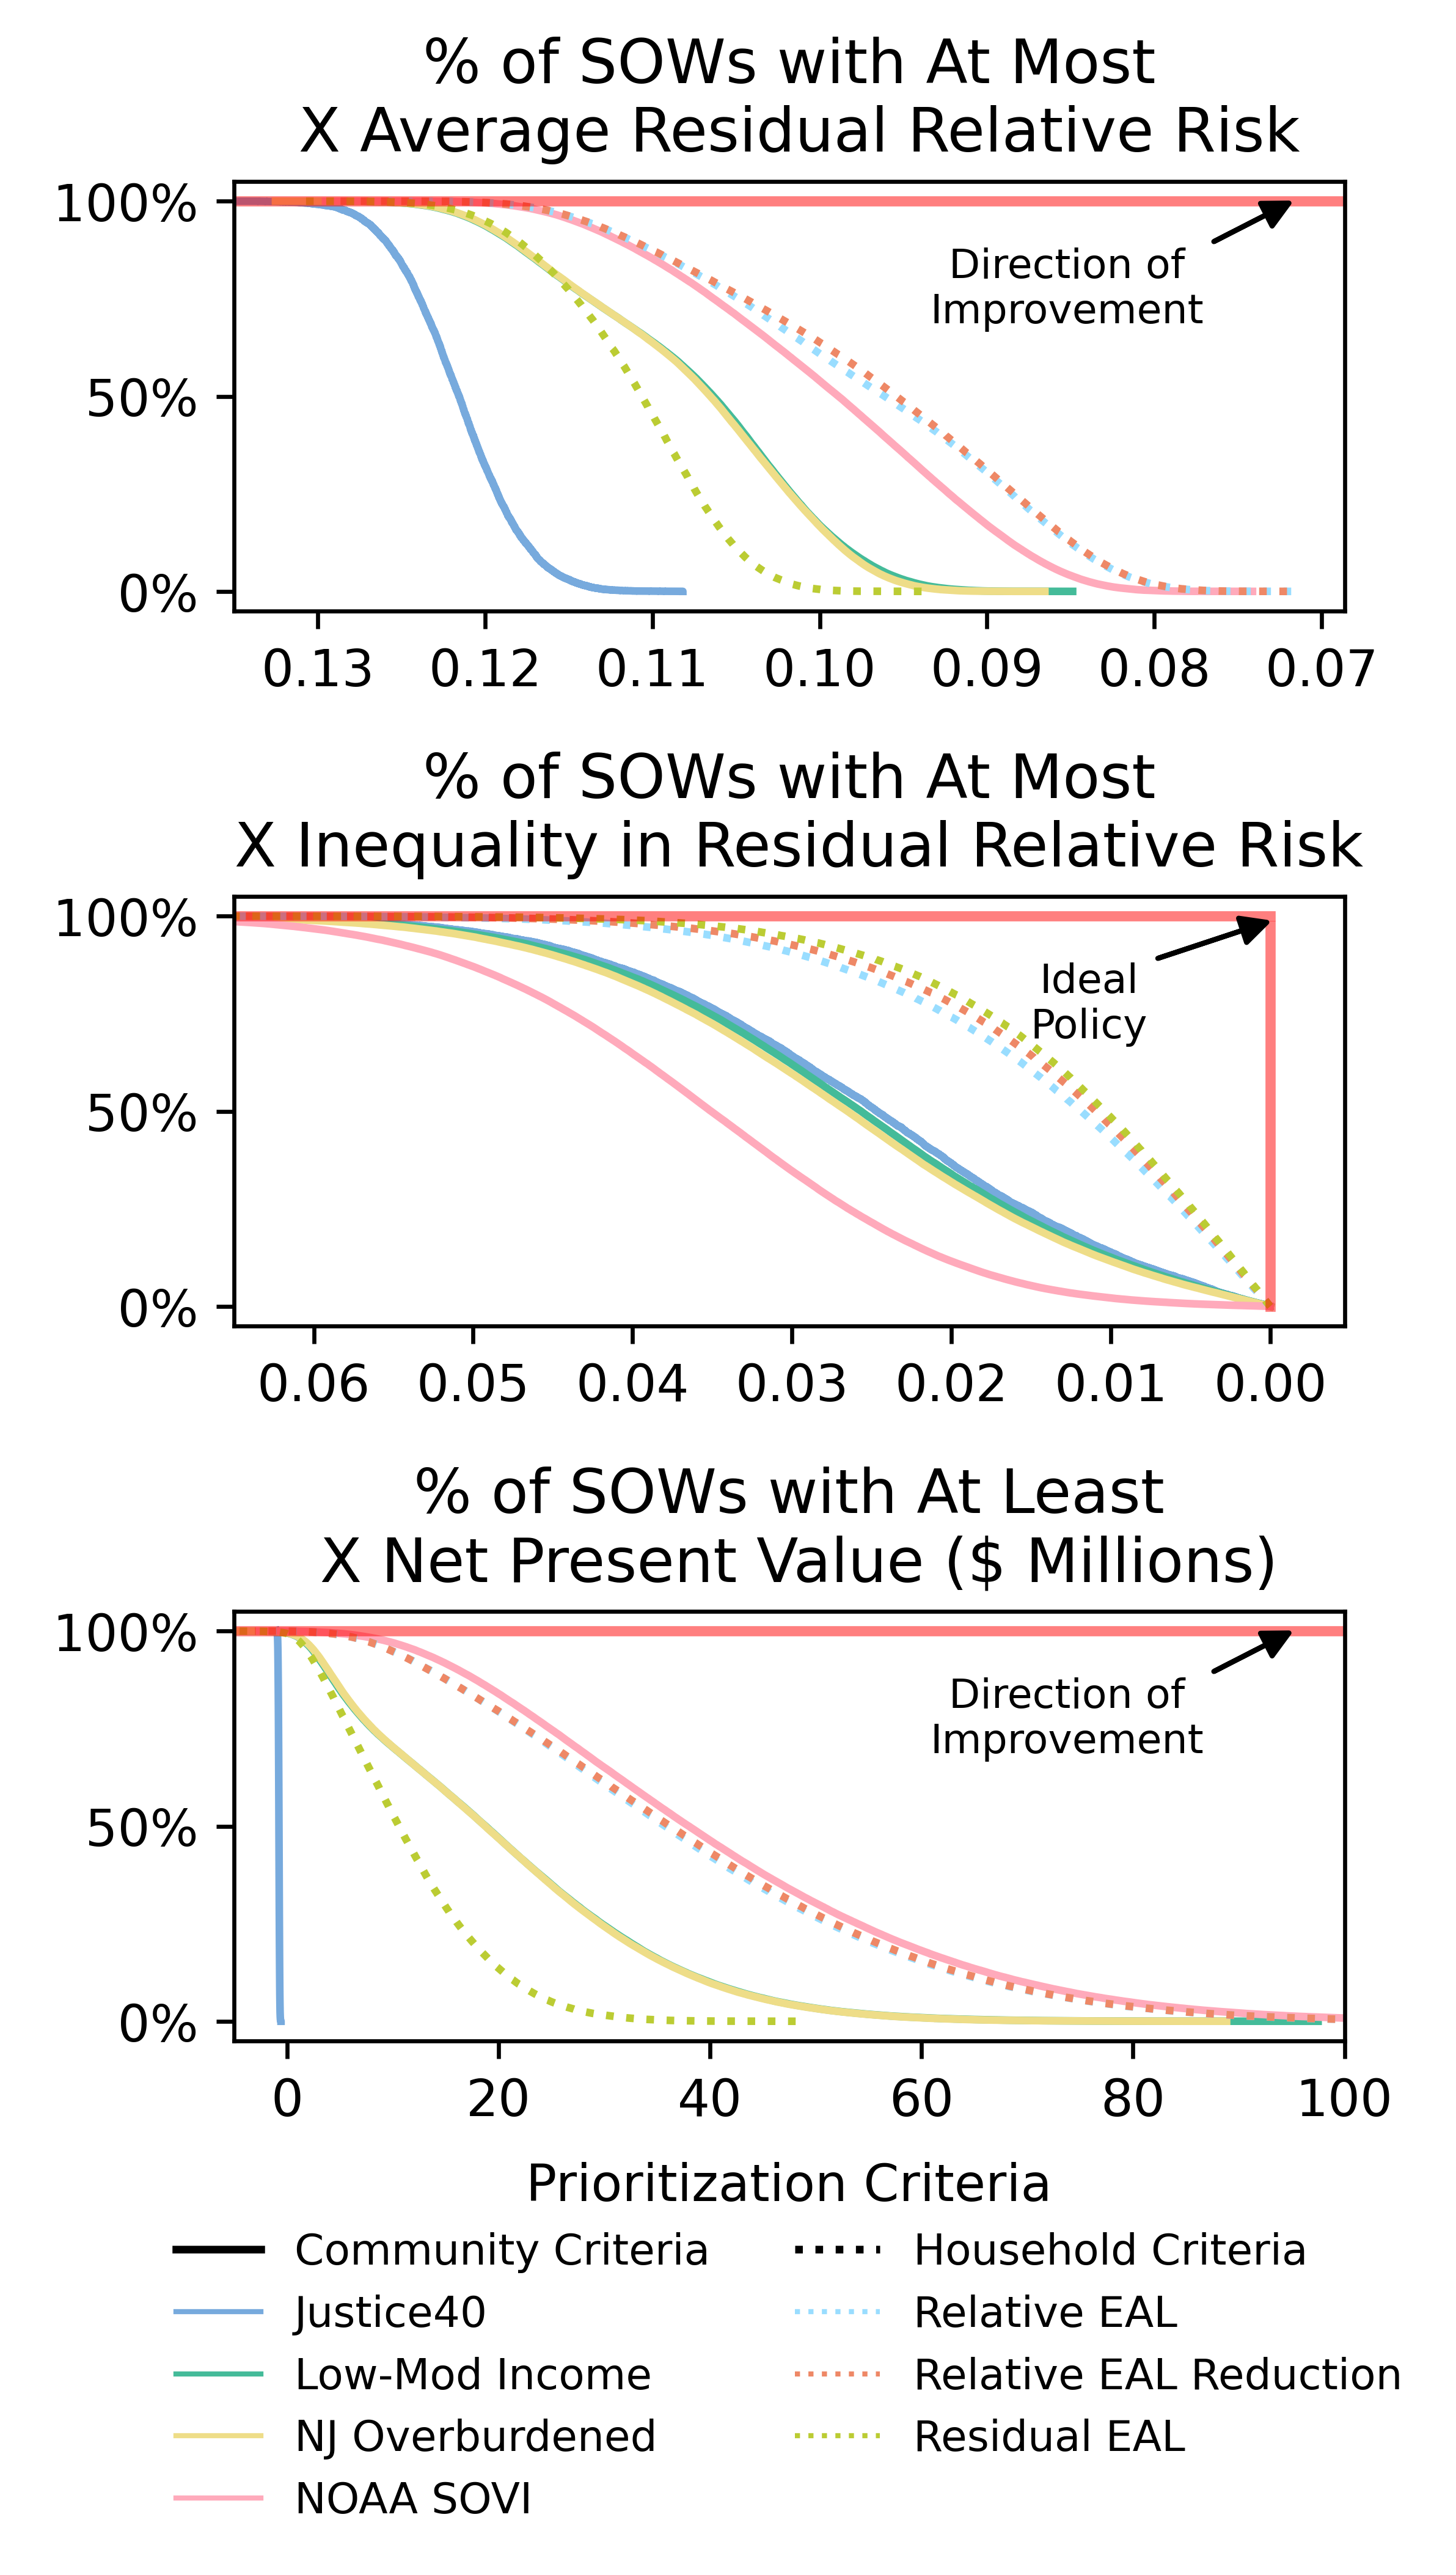

In [72]:
# Figure 3
# Want to show marginal distributions for the 2 equity metrics
# and the npv for the different sorting rules. We will do
# community and household rules on different rows. We will
# do the different metrics as different columns
# So this is a grid axis
# Do histograms (budgets are changing)
# Says nothing direclty about the pareto front, but hints at what
# policies dominate on different dimensions
# And this is especially important for the story of our paper
# comparing community prioritization criteria to 
# household equity indicators
# Gives us the visual cues to talk about sovi dominating cejst
# even though FEMA just changed from sovi to cejst
# Allows us to explain that new FEMA critical disaster 
# resilience zones are not even in our community
# Allows us to show that the rel_eal based sorting (household
# equity indicators) dominates efficiency based sorting (i.e. npv)
# Need to make it so that all axes share the same direction
# of prference. I think that is visually nicer
# Community rules are different colors & dotted
# Household "" & solid (different colors than above)
# No fill on the histograms
# Share x axis no columns & y axis all

# Using the "light" scheme
# https://cran.r-project.org/web/packages/khroma/vignettes/tol.html
# Colors dict
color_dict = {
    'cejst': "#77AADD",
    'lmi': "#44BB99",
    'ovb': "#EEDD88",
    'sovi': "#FFAABB",
    'rel_eal': "#99DDFF",
    'avoid_rel_eal': "#EE8866",
    'pv_resid': "#BBCC33"
}

# We need the objs_sows dataframe

fig, ax = plt.subplots(figsize=(4, 6),
                       nrows=3,
                       ncols=1,
                       dpi=600)

# We are looping through avoid_eq, resid_eq, and npv
plot_cols = ['avoid_eq', 'resid_eq', 'npv_plot']
# NPV in millions plots better
objs_sows['npv_plot'] = objs_sows['npv']/1e6

# We are plotting community sorting rules on the top row
# and the household sorting rules on the bottom 
sort_cols =  ['cejst', 'lmi', 'ovb', 'sovi',
              'rel_eal', 'avoid_rel_eal',
              'pv_resid']

# We can get subsets based on these policies to help with plotting
marg = objs_sows[objs_sows['sort'].isin(sort_cols)].reset_index(drop=True)

# We loop through the plot cols
# For each one, we want to pivot on sow_ind/budget index
# with the sort columns as columns and the plot_col as the value
for i, pc in enumerate(plot_cols):
    hist = marg.pivot(index=['sow_ind', 'budget'],
                      columns='sort',
                      values=pc).reset_index()

    # For each sort column, sc, we are going to call
    # x = np.flip(np.sort(hist[sc])), then
    # y = np.arange(len(hist))/len(hist)
    # Actually, we only flip for npv!
    # So, check which i we are at
    # Then we can just draw the line plot
    for j, sc in enumerate(sort_cols):
        
        x = np.sort(hist[sc])
        if i > 1:
            x = np.flip(x)
        y = np.arange(len(x))/len(x)

        # If j is <=3, community criteria & solid line
        ls = 'solid' if j < 4 else 'dotted'
    
        ax[i].plot(x, y,
                   ls=ls,
                   color=color_dict[sc])
    
    # Percentage y axis
    reformat = "{x: .0%}"
    ax[i].yaxis.set_major_formatter(ticker.StrMethodFormatter(reformat))

    # For i < 2, invert x-axis (want all same direction)
    if i < 2:
        ax[i].set_xlim(ax[i].get_xlim()[::-1])

# Label each column
ax[0].set_title('% of SOWs with At Most\n X Average Residual Relative Risk', size=12)
ax[1].set_title('% of SOWs with At Most\n X Inequality in Residual Relative Risk', size=12)
ax[2].set_title('% of SOWs with At Least\n X Net Present Value ($ Millions)', size=12)


# We can trim axes a bit to remove area that is creating too much
# white space
ax[0].set_xlim(.135, ax[0].get_xlim()[1])
ax[1].set_xlim(.065, ax[1].get_xlim()[1])
ax[2].set_xlim(-5, 100)

# I also want to create an example of what the "ideal" 
# distribution would look like for each axis
# For each axis, we go from the lower to upper limit
# and generate a straight line at 100%
for i in [0, 1, 2]:
    x = np.linspace(ax[i].get_xlim()[0], ax[i].get_xlim()[1])
    y = np.ones_like(x)
    y[-1] = 0
    x = np.append(x, [ax[i].get_xlim()[1]])
    y = np.append(y, [0])
    if i != 1:
        ax[i].axhline(y=1,
                      lw=2,
                      alpha=.5,
                      color='red')
    else:
        # Draw horizontal line to 0 (x-axis)
        ax[i].plot((ax[i].get_xlim()[0], 0),
                   (1, 1),
                   color='red',
                   alpha=.5,
                   lw=2)
        # Draw vertical line to 0 (y-axis)
        ax[i].plot((0, 0),
                   (.97449, 0),
                   color='red',
                   alpha=.5,
                   lw=2)
    

# Annotate direction of improvement
# for i = 0 and 2
for i in [0, 2]:
    ax[i].annotate('Direction of\nImprovement',
                   xy=(.95, .95), xycoords='axes fraction',
                   xytext=(0.75, 0.75), textcoords='axes fraction',
                   arrowprops=dict(facecolor='black',
                                   width=.01,
                                   headlength=5,
                                   headwidth=5),
                   fontsize=8,
                   horizontalalignment='center',
                   verticalalignment='center')

# Annotate ideal policy
ax[1].annotate('Ideal\nPolicy',
               xy=(.93, .94), xycoords='axes fraction',
               xytext=(0.77, 0.75), textcoords='axes fraction',
               arrowprops=dict(facecolor='black',
                               width=.01,
                               headlength=5,
                               headwidth=5),
               fontsize=8,
               horizontalalignment='center',
               verticalalignment='center')

fig.tight_layout()

# Add custom legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], color='black', label='Community Criteria'),
                   Line2D([0], [0], color="#77AADD", lw=1,
                          label='Justice40'),
                   Line2D([0], [0], color="#44BB99", lw=1,
                          label='Low-Mod Income'),
                   Line2D([0], [0], color="#EEDD88", lw=1,
                          label='NJ Overburdened'),
                   Line2D([0], [0], color="#FFAABB", lw=1,
                          label='NOAA SOVI'),
                   Line2D([0], [0], color='black', label='Household Criteria',
                          ls="dotted"),
                   Line2D([0], [0], color="#99DDFF", lw=1, ls="dotted",
                          label='Relative EAL'),
                   Line2D([0], [0], color="#EE8866", lw=1, ls="dotted",
                          label='Relative EAL Reduction'),
                   Line2D([0], [0], color="#BBCC33", lw=1, ls="dotted",
                          label='Residual EAL')]

ax[2].legend(handles=legend_elements,
             loc='center',
             ncol = 2,
             fontsize='small',
             title="Prioritization Criteria",
             frameon=False,
             bbox_to_anchor=(.5, -.7))

fig.savefig(join(FIG_DIR, 'Figure3.png'),
            dpi=600,
            bbox_inches='tight')

In [ ]:
# Figure 4
# Parallel axis plot
# 2 panels where top is a horizontal bar
# Shows policies on y-axis sorted from top to bottom in terms
# of how many pareto policies come from the sorting rule
# And x-axis shows the count
# We do horizontal for increased readability of the policy names
# This sneakily serves as our plot legend since we will
# color the bars

# The bottom panel uses the colors for each bar for plotting
# the lines associated with each policy
# I just want to plot the pareto optimal policies
# The key is to highlight tradeoffs across objectives on a per-policy
# basis
# It might also be worth showing -- in grayed out lines -- 
# the policies that are pareto optimal if you only use community
# prioritization criteria. This is just to show how much
# these are pareto dominated by the full pareto front. But
# it might be too much clutter. It might be easy enough
# to compare the hypervolume separating the two pareto fronts
# and make this point in text as opposed to visually, though
# both would be ideal

# We need the pareto_f dataframe, and maybe the pareto_c one
# for testing out the second idea

# Main Summary Stats

# Supplementary Figures

# Supplementary Summary Stats